In [2]:
#Importer les dépendances
import pymysql
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

In [3]:
# Se Connecter à la BDD foody
conn = pymysql.connect(host='Localhost',user='root',passwd='&Rox@ne68!', database='foody')
if conn:
    print("Connection Successful!")
else:
    print("Connection Failed!")
cur = conn.cursor()
#cur.execute("SHOW DATABASES")
cur.execute("select * from produit limit 2")
for row in cur:
    print(row)

Connection Successful!
(1, 'Chai', 1, 1, '10 boxes x 20 bags', 18.0, 39, 0, 10, 0)
(2, 'Chang', 1, 1, '24 - 12 oz bottles', 19.0, 17, 40, 25, 0)


In [4]:
# définir la fct sql_to_pandas

def sql_to_df(sql_query):

    # Use pandas to pass sql query using connection form SQLite3
    df = pd.read_sql(sql_query, conn)

    # Show the resulting DataFrame
    return df

Le chiffre d'affaire :
    - global par mois et par trimestre
    - par pays
    - par produit
    - par categorie

<AxesSubplot:xlabel='mois', ylabel='CAmensuel'>

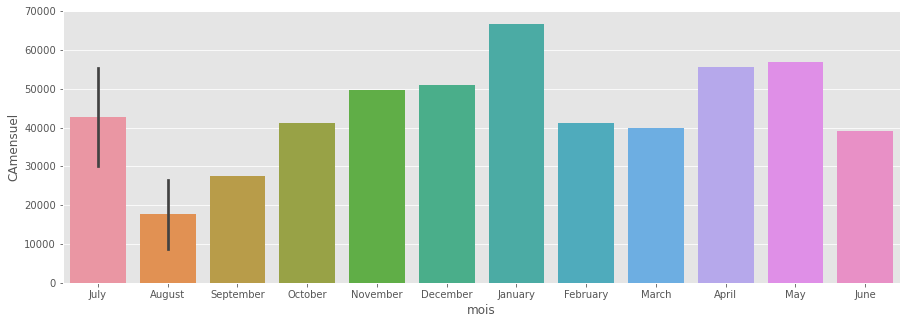

In [6]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)

query = ''' SELECT MONTHNAME(dateCom) AS mois, ROUND(SUM(prixUnit*qte),2) AS CAmensuel FROM detailCommande 
INNER JOIN commande USING(noCom)
GROUP BY YEAR(dateCom), MONTH(dateCom) '''

sns.barplot(x="mois", y="CAmensuel", data=sql_to_df(query))

<AxesSubplot:xlabel='trimestre', ylabel='CAtrimestriel'>

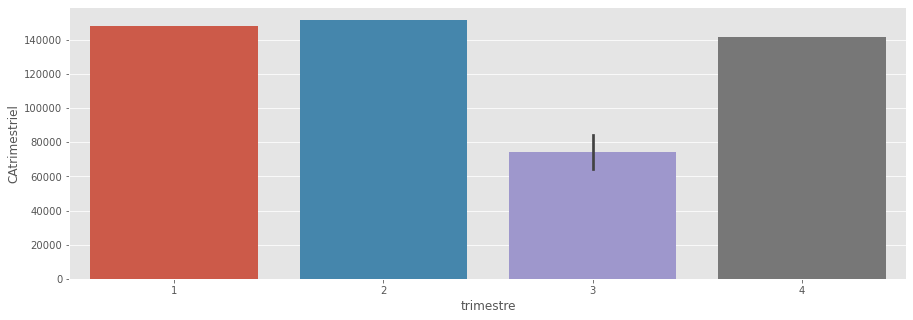

In [43]:
query = ''' SELECT YEAR(dateCom), QUARTER(dateCom) AS trimestre, ROUND(SUM(prixUnit*qte),2) AS CAtrimestriel FROM detailCommande 
INNER JOIN commande USING(noCom)
GROUP BY YEAR(dateCom), QUARTER(dateCom) '''

sns.barplot(x="trimestre", y="CAtrimestriel", data=sql_to_df(query))

In [29]:
# generate country code  based on country name 
import pycountry 

In [30]:
query = ''' SELECT paysLiv, ROUND(SUM(prixUnit*qte),2) AS CAtotal, REPLACE(REPLACE(paysLiv, 'USA', 'United States'), 'UK', 'United Kingdom') AS countries FROM detailCommande 
INNER JOIN commande USING(noCom) GROUP BY paysLiv ORDER BY CAtotal DESC'''

dfCApays=sql_to_df(query)
def alpha2code(column):
    CODE=[]
    for country in column:
        try:
            code=pycountry.countries.get(name=country).alpha_2
           # .alpha_3 means 3-letter country code 
           # .alpha_2 means 2-letter country code
            CODE.append(code)
        except:
            CODE.append('None')
    return CODE
# create a column for code 
dfCApays['CODE']=alpha2code(dfCApays.countries)
dfCApays

,paysLiv,CAtotal,countries,CODE
0,USA,110650.93,United States,US
1,Germany,105574.40,Germany,DE
2,Austria,62363.90,Austria,AT
3,France,43531.30,France,FR
4,Brazil,42030.38,Brazil,BR
5,Canada,39163.20,Canada,CA
6,UK,27092.35,United Kingdom,GB
7,Venezuela,26541.40,Venezuela,None
8,Ireland,20082.50,Ireland,IE
9,Sweden,19114.00,Sweden,SE


In [31]:
from geopy.exc import GeocoderTimedOut 
from geopy.geocoders import Nominatim 

# declare an empty list to store 
# latitude and longitude of values 
# of paysLiv column 
longitude = [] 
latitude = [] 

# function to find the coordinate 
# of a given city or country
def findGeocode(country): 
	
	# try and catch is used to overcome 
	# the exception thrown by geolocator 
	# using geocodertimedout 
	try: 
		
		# Specify the user_agent as your 
		# app name it should not be none 
		geolocator = Nominatim(user_agent="cartePays") 
		
		return geolocator.geocode(country) 
	
	except GeocoderTimedOut: 
		
		return findGeocode(country)	 

# each value from paysLiv column 
# will be fetched and sent to 
# function find_geocode 
for i in (dfCApays["paysLiv"]): 
	
	if findGeocode(i) != None: 
		
		loc = findGeocode(i) 
		
		# coordinates returned from 
		# function is stored into 
		# two separate list 
		latitude.append(loc.latitude) 
		longitude.append(loc.longitude) 
	
	# if coordinate for a country or city not 
	# found, insert "NaN" indicating 
	# missing value 
	else: 
		latitude.append(np.nan) 
		longitude.append(np.nan) 


In [32]:
# now add this column to dataframe 
dfCApays["Longitude"] = longitude 
dfCApays["Latitude"] = latitude 

dfCApays 


,paysLiv,CAtotal,countries,CODE,Longitude,Latitude
0,USA,110650.93,United States,US,-100.445882,39.783730
1,Germany,105574.40,Germany,DE,10.423447,51.083420
2,Austria,62363.90,Austria,AT,13.200000,47.200000
3,France,43531.30,France,FR,1.888334,46.603354
4,Brazil,42030.38,Brazil,BR,-53.200000,-10.333333
5,Canada,39163.20,Canada,CA,-107.991707,61.066692
6,UK,27092.35,United Kingdom,GB,-3.276575,54.702354
7,Venezuela,26541.40,Venezuela,None,-66.110932,8.001871
8,Ireland,20082.50,Ireland,IE,-7.979460,52.865196
9,Sweden,19114.00,Sweden,SE,14.520858,59.674971


In [35]:
# Create a world map to show distributions of gross sales between countries
import folium
from folium.plugins import MarkerCluster
#empty map
world_map= folium.Map(tiles="cartodbpositron")
marker_cluster = MarkerCluster().add_to(world_map)
#for each coordinate, create circlemarker of CApays
for i in range(len(dfCApays)):
        lat = dfCApays.iloc[i]['Latitude']
        long = dfCApays.iloc[i]['Longitude']
        radius= (dfCApays.iloc[i]['CAtotal'])/1000
        popup_text = """Country : {}<br>
                    total CA : {}<br>"""
        popup_text = popup_text.format(dfCApays.iloc[i]['paysLiv'],
                                   dfCApays.iloc[i]['CAtotal']
                                   )
        folium.CircleMarker(location = [lat, long], radius=radius, popup= popup_text, fill =True).add_to(marker_cluster)
#show the map
world_map

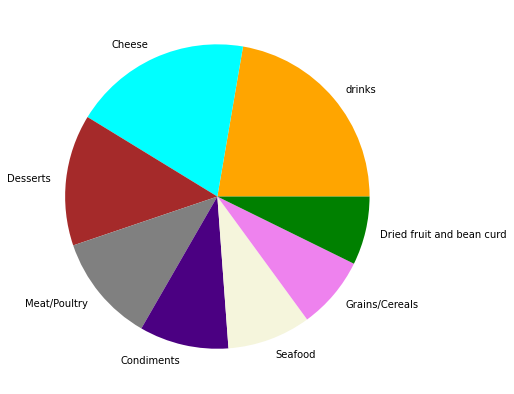

In [84]:
query = ''' SELECT nomCateg, ROUND(SUM(detailCommande.prixUnit*detailCommande.qte),2) AS CAtotal 
FROM detailCommande   
INNER JOIN produit USING(refProd)
INNER JOIN categorie USING(codeCateg)
GROUP BY codeCateg ORDER BY CAtotal DESC '''

sql_to_df(query)

categorie = ['drinks', 'Cheese', 'Desserts', 'Meat/Poultry', 'Condiments', 'Seafood', 'Grains/Cereals', 'Dried fruit and bean curd'] 
  
CAtotal = [131558, 111827, 82273, 67724, 55943, 52345, 45345, 42918] 
colors = ( "orange", "cyan", "brown", 
          "grey", "indigo", "beige","violet","green")   
# Creating plot 
fig = plt.figure(figsize =(10, 7)) 
plt.pie(CAtotal, labels = categorie, colors = colors) 
  
# show plot 
plt.show() 

Le top 10 des produits en fonction de leur chiffre d'affaires

<AxesSubplot:xlabel='CAtotal', ylabel='nomProd'>

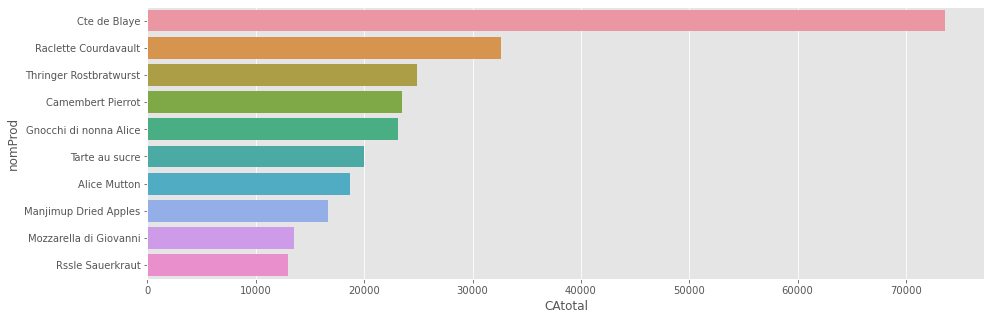

In [41]:
query = ''' SELECT nomProd, ROUND(SUM(detailCommande.prixUnit*detailCommande.qte),2) AS CAtotal
FROM detailCommande 
INNER JOIN commande USING(noCom)  
INNER JOIN produit USING(refProd) 
GROUP BY refProd ORDER BY CAtotal DESC
LIMIT 10'''

sns.barplot(x="CAtotal", y="nomProd", data=sql_to_df(query))

Comparaison du nombre de commande en fonction de l'année et du sexe de l'employé 

<AxesSubplot:xlabel='year', ylabel='totalCom'>

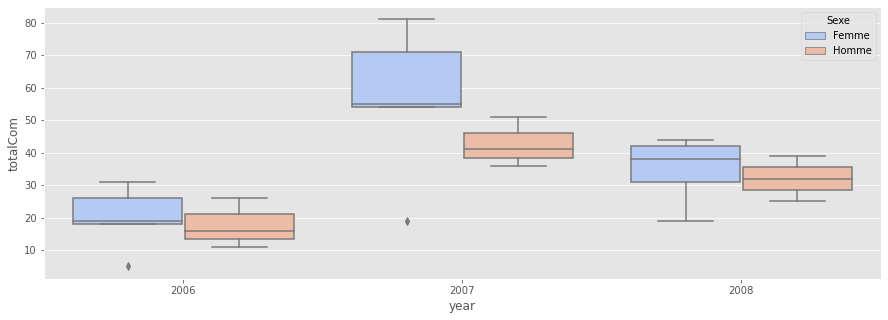

In [7]:
query = ''' SELECT YEAR(dateCom) AS year, COUNT(commande.noCom) AS totalCom, 
CASE WHEN (titreCourtoisie LIKE "%s%") THEN "Femme"
ELSE "Homme"
END AS Sexe 
FROM commande 
 INNER JOIN employe USING(noEmp)
 GROUP BY noEmp, YEAR(dateCom) '''
#sql_to_df(query)
sns.boxplot(x="year", y="totalCom", hue="Sexe",data=sql_to_df(query), palette="coolwarm")

Comparaison du nombre de commande en fonction de l'année et du pays de l'employé

<AxesSubplot:xlabel='year', ylabel='totalCom'>

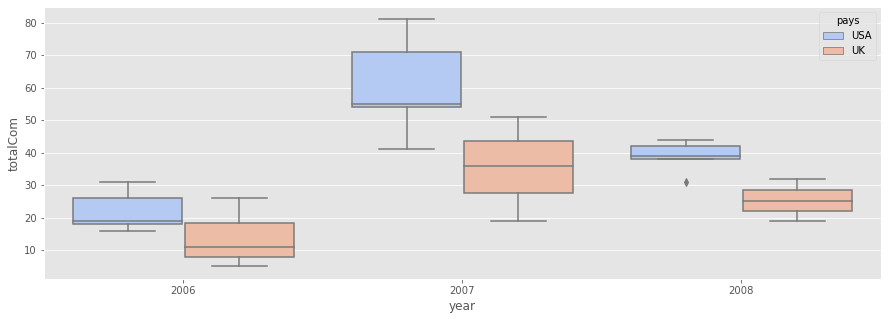

In [77]:
query = ''' SELECT YEAR(dateCom) AS year, COUNT(commande.noCom) AS totalCom, pays 
FROM commande 
 INNER JOIN employe USING(noEmp)
 GROUP BY noEmp, YEAR(dateCom) '''

sns.boxplot(x="year", y="totalCom", hue="pays",data=sql_to_df(query), palette="coolwarm")

Comparaison du nombre de commande en fonction de l'année et du N+1 de l'employé

<AxesSubplot:xlabel='year', ylabel='totalCom'>

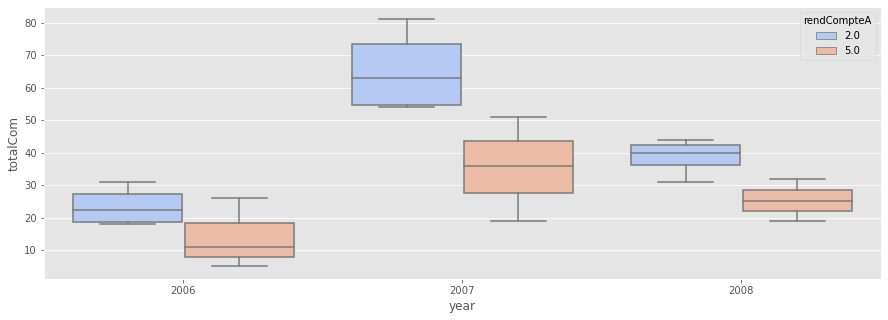

In [78]:
query = ''' SELECT YEAR(dateCom) AS year, COUNT(commande.noCom) AS totalCom, rendCompteA 
FROM commande 
 INNER JOIN employe USING(noEmp)
 GROUP BY noEmp, YEAR(dateCom) '''

sns.boxplot(x="year", y="totalCom", hue="rendCompteA",data=sql_to_df(query), palette="coolwarm")
# noEmp = 2 = Fuller Andrew VP USA, noEmp = 5 = Buchanan Steven Sales Mana UK 